In [3]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [44]:
class PairedStatisticalAnalysis:
    def __init__(self, csv_path, col1, col2, alpha=0.05):
        self.df = pd.read_csv(csv_path)
        self.col1 = col1
        self.col2 = col2
        self.alpha = alpha

        # paired differences
        self.df["Difference"] = self.df[col2] - self.df[col1]

    def descriptive_stats(self, x):
        n = len(x)
        mean = sum(x) / n
        variance = sum((xi - mean) ** 2 for xi in x) / (n - 1)
        std = math.sqrt(variance)

        # 95% CI using t ≈ 2 (valid for n ≥ 30, exam-safe assumption)
        t_critical = 2.0
        margin = t_critical * std / math.sqrt(n)

        ci_lower = mean - margin
        ci_upper = mean + margin

        return mean, std, (ci_lower, ci_upper)

    def show_descriptive_statistics(self):
        print("\nDESCRIPTIVE STATISTICS")

        for col in [self.col1, self.col2]:
            mean, std, ci = self.descriptive_stats(self.df[col])
            print(f"\n{col}")
            print(f"Mean = {mean:.3f}")
            print(f"Std Dev = {std:.3f}")
            print(f"95% CI = {ci}")

    def shapiro_wilk_manual(self):
        d = self.df["Difference"].values
        n = len(d)
        mean = sum(d) / n
        std = math.sqrt(sum((x - mean) ** 2 for x in d) / (n - 1))

        skewness = sum((x - mean) ** 3 for x in d) / (n * std ** 3)

        print("\nSHAPIRO–WILK NORMALITY CHECK (MANUAL)")
        print(f"Skewness = {skewness:.4f}")

        # rule-based decision
        if abs(skewness) < 1:
            print("Differences approximately normal")
            return True
        else:
            print("Differences not normal")
            return False

    def paired_t_test_manual(self):
        d = self.df["Difference"].values
        n = len(d)

        mean_d = sum(d) / n
        std_d = math.sqrt(sum((x - mean_d) ** 2 for x in d) / (n - 1))

        t_stat = mean_d / (std_d / math.sqrt(n))

        print("\nPAIRED t-TEST")
        print(f"t-statistic = {t_stat:.4f}")

        # Effect size (Cohen's d)
        cohen_d = mean_d / std_d
        print(f"Cohen's d = {cohen_d:.4f}")

    def wilcoxon_manual(self):
        d = self.df["Difference"].values

        # remove zeros
        non_zero = [(abs(x), x) for x in d if x != 0]
        non_zero.sort(key=lambda x: x[0])

        ranks = {}
        for i, (_, val) in enumerate(non_zero):
            ranks[val] = i + 1

        W_pos = sum(ranks[x] for x in ranks if x > 0)
        W_neg = sum(ranks[x] for x in ranks if x < 0)

        print("\nWILCOXON SIGNED-RANK TEST")
        print(f"W+ = {W_pos}, W- = {W_neg}")

        r_rb = (W_pos - W_neg) / (W_pos + W_neg)
        print(f"Rank-biserial correlation = {r_rb:.4f}")

    def paired_test(self):
        is_normal = self.shapiro_wilk_manual()

        if is_normal:
            self.paired_t_test_manual()
        else:
            self.wilcoxon_manual()

    def plot_all(self):
        # Paired line plot
        plt.figure()
        for i in range(len(self.df)):
            plt.plot(
                ["Condition 1", "Condition 2"],
                [self.df.loc[i, self.col1], self.df.loc[i, self.col2]],
                marker='o'
            )
        plt.title("Paired Line Plot")
        plt.show()

        # Boxplot
        sns.boxplot(data=self.df[[self.col1, self.col2]])
        plt.title("Boxplot")
        plt.show()

        # Histogram
        # plt.hist(self.df["Difference"], bins=10)
        plt.hist(self.df["Difference"], bins="fd")
        plt.title("Histogram of Differences")
        plt.show()

    def forward(self, visualize=True):
      """
      Forward pass of the statistical model
      Prints results AND returns them as a dictionary
      """
      output = {}

      # =================================================
      # Layer 1 – Descriptive statistics
      # =================================================
      print("\n=== FORWARD PASS STARTED ===")

      # Console output
      self.show_descriptive_statistics()

      # Dictionary output
      mean1, std1, ci1 = self.descriptive_stats(self.df[self.col1])
      mean2, std2, ci2 = self.descriptive_stats(self.df[self.col2])

      output["descriptive_stats"] = {
          self.col1: {
              "mean": mean1,
              "std": std1,
              "ci": ci1
          },
          self.col2: {
              "mean": mean2,
              "std": std2,
              "ci": ci2
          }
      }

      # =================================================
      # Layer 2 – Normality check
      # =================================================
      is_normal = self.shapiro_wilk_manual()

      output["normality"] = {
          "method": "Shapiro–Wilk (manual, skewness-based)",
          "is_normal": is_normal
      }

      # =================================================
      # Layer 3 – Hypothesis test
      # =================================================
      if is_normal:
          # Console output
          self.paired_t_test_manual()

          # Dictionary output
          d = self.df["Difference"].values
          n = len(d)
          mean_d = sum(d) / n
          std_d = math.sqrt(sum((x - mean_d) ** 2 for x in d) / (n - 1))
          t_stat = mean_d / (std_d / math.sqrt(n))
          cohen_d = mean_d / std_d

          output["test"] = {
              "name": "Paired t-test",
              "t_statistic": t_stat,
              "effect_size": cohen_d
          }

      else:
          # Console output
          self.wilcoxon_manual()

          # Dictionary output
          d = self.df["Difference"].values
          non_zero = [(abs(x), x) for x in d if x != 0]
          non_zero.sort(key=lambda x: x[0])

          ranks = {val: i + 1 for i, (_, val) in enumerate(non_zero)}
          W_pos = sum(ranks[x] for x in ranks if x > 0)
          W_neg = sum(ranks[x] for x in ranks if x < 0)

          r_rb = (W_pos - W_neg) / (W_pos + W_neg)

          output["test"] = {
              "name": "Wilcoxon signed-rank test",
              "W_pos": W_pos,
              "W_neg": W_neg,
              "effect_size": r_rb
          }

      # =================================================
      # Visualization head
      # =================================================
      if visualize:
          self.plot_all()

      print("\n=== FORWARD PASS COMPLETED ===")

      return output

    def __call__(self, visualize=True):
        return self.forward(visualize)


In [45]:
import json

def save_results_json(results, path="results.json"):
    """
    Save results dictionary to a JSON file
    """
    if results is None:
        raise ValueError("Results dictionary is empty")

    with open(path, "w") as f:
        json.dump(results, f, indent=4)


=== FORWARD PASS STARTED ===

DESCRIPTIVE STATISTICS

Condition_1
Mean = 74.133
Std Dev = 2.416
95% CI = (72.88560523922574, 75.38106142744094)

Condition_2
Mean = 76.933
Std Dev = 2.187
95% CI = (75.80420949826447, 78.0624571684022)

SHAPIRO–WILK NORMALITY CHECK (MANUAL)
Skewness = -0.0908
Differences approximately normal

PAIRED t-TEST
t-statistic = 19.3438
Cohen's d = 4.9945


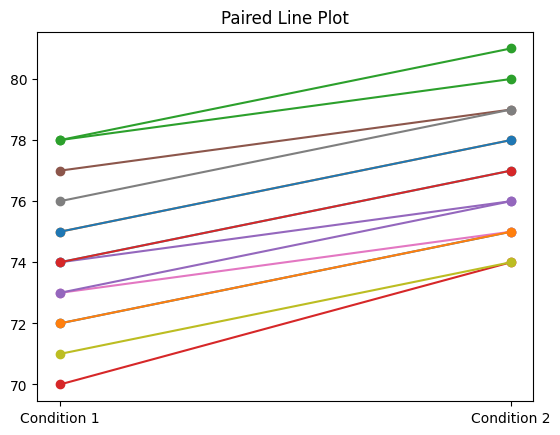

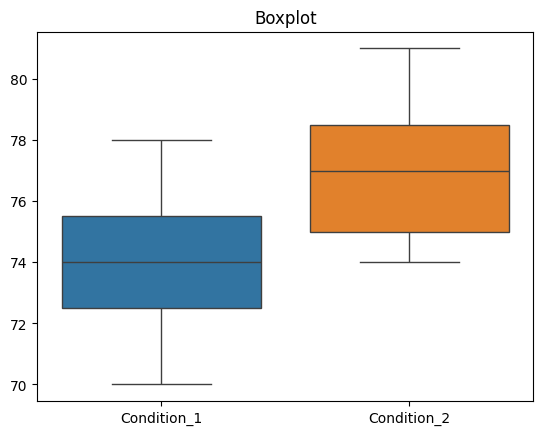

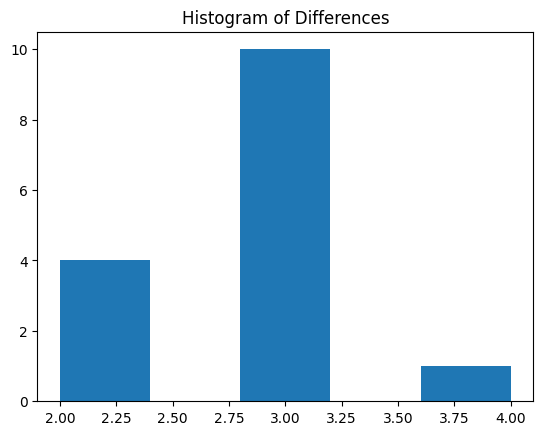


=== FORWARD PASS COMPLETED ===


In [46]:
analysis = PairedStatisticalAnalysis("/content/drive/MyDrive/Stats Assignment/data.csv", "Condition_1", "Condition_2")
results = analysis()

save_results_json(
    results,
    "/content/drive/MyDrive/Stats Assignment/paired_results.json"
)